In [17]:
import os
import cv2
import torch
import random
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.patches as patches
from torch.utils.data import Dataset, DataLoader, Subset

class HandwrittenDigitsDataset(Dataset):
    def __init__(self, images_folder, transform=None):
        self.images_folder = images_folder
        self.transform = transform
        self.image_files = [os.path.join(images_folder, f) for f in os.listdir(images_folder) if f.endswith('.png')]
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        label_path = img_path.replace('.png', '.txt')
        labels = []
        with open(label_path, 'r') as f:
            for line in f:
                label_data = line.strip().split('\t')
                digit_label = int(label_data[0])
                bbox_coords = [float(coord) for coord in label_data[1:]]
                labels.append([digit_label] + bbox_coords)

        while len(labels) < 4:
            labels.append([-1, -1, -1, -1, -1])
            
        if self.transform:
            image = self.transform(image)
        labels = np.array(labels, dtype=np.float32)
        return image, labels

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
path = "D:\Casper\OTHER\Data\\aML\hw6\HW6_train\\5\\"


train_dataset = HandwrittenDigitsDataset(path, transform)
print(len(train_dataset))

96000


In [18]:
def custom_collate_fn(batch):
    images = []
    labels = []

    for image, label in batch:
        images.append(image)
        labels.append(torch.tensor(label, dtype=torch.float32))
        
    images = torch.stack(images, 0)
    labels = torch.stack(labels, 0)

    return images, labels
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=custom_collate_fn)


In [19]:
def get_dataloaders(train_dataset, transform, train_ratio, val_ratio, batch_size):

    # obtain training indices that will be used for validation
    num_train = len(train_dataset)
    indices = list(range(num_train))
    print("--------- INDEX checking ---------")
    print(f"Original: {indices[:5]}")
    random.shuffle(indices)
    print(f"Shuffled: {indices[:5]}")
    print("--------- INDEX shuffled ---------\n")

    split_train = int(np.floor(train_ratio * num_train))
    split_val = split_train + int(np.floor(val_ratio * (num_train-split_train)))
    train_idx, val_idx, test_idx = indices[0:split_train], indices[split_train:split_val], indices[split_val:]
    merge_dataset = Subset(train_dataset, train_idx)

    train_loader = DataLoader(merge_dataset, batch_size=batch_size, collate_fn=custom_collate_fn)
    val_loader = DataLoader(Subset(train_dataset, val_idx), batch_size=batch_size, collate_fn=custom_collate_fn)
    test_loader = DataLoader(Subset(train_dataset, test_idx), batch_size=batch_size, collate_fn=custom_collate_fn)
    
    # check dataset
    print(f"Total number of samples: {num_train} datapoints")
    print(f"Number of train samples: {len(train_loader)} batches/ {len(train_loader.dataset)} datapoints")
    print(f"Number of val samples: {len(val_loader)} batches/ {len(val_loader.dataset)} datapoints")
    print(f"Number of test samples: {len(test_loader)} batches/ {len(test_loader.dataset)} datapoints")
    print(f"Data Transform: {transform}")
    print(f"")
    
    dataloaders = {
        "train": train_loader,
        "val": val_loader,
        "test": test_loader,
    }
    return dataloaders

In [29]:
loaders = get_dataloaders(train_dataset, transform, 0.8, 0.5, 64)


--------- INDEX checking ---------
Original: [0, 1, 2, 3, 4]
Shuffled: [67219, 74248, 72010, 91417, 26124]
--------- INDEX shuffled ---------

Total number of samples: 96000 datapoints
Number of train samples: 1200 batches/ 76800 datapoints
Number of val samples: 150 batches/ 9600 datapoints
Number of test samples: 150 batches/ 9600 datapoints
Data Transform: Compose(
    ToPILImage()
    Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=(0.5,), std=(0.5,))
)



Label:
 [[ 0.         0.515625   0.40625    0.21875    0.21875  ]
 [ 3.         0.015625   0.7734375  0.21875    0.21875  ]
 [ 4.         0.65625    0.7109375  0.21875    0.21875  ]
 [-1.        -1.        -1.        -1.        -1.       ]]


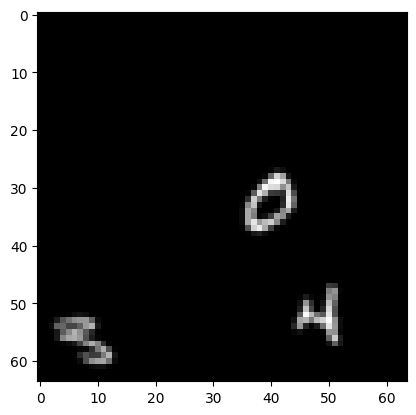

In [30]:
def display_image_and_tensor(dataset, index):
    image, label = dataset[index]  # Get the first image and its label
    print("Label:\n", label)
    image_np = image.squeeze().numpy()  
    plt.imshow(image_np, cmap='gray')
    plt.show()

display_image_and_tensor(train_dataset, 1)

In [31]:
count = 0
for label in train_loader:
    count +=1
    if count >5:
        print(len(label[0]))
        break

8


In [32]:


class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 4 * 5)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.view(-1, 4, 5)  # Reshape to (batch_size, 4, 5)
        return x

model = SimpleCNN()


In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 4 * 5)  # 5 bounding box coordinates + 1 confidence score
    
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = x.view(-1, 256 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = x.view(-1, 4, 5)  # Reshape to (batch_size, 4, 6)
        return x

model = ImprovedCNN()


In [34]:
def calculate_iou(pred_box, true_box):
    """
    Calculate the IoU of two bounding boxes.

    Parameters:
    pred_box (Tensor): Predicted bounding box of shape (4,) in the format [x, y, w, h].
    true_box (Tensor): True bounding box of shape (4,) in the format [x, y, w, h].

    Returns:
    float: IoU value.
    """
    if isinstance(pred_box, np.ndarray):
        pred_box = torch.tensor(pred_box)
    if isinstance(true_box, np.ndarray):
        true_box = torch.tensor(true_box)
    # Transform from center coordinates to corner coordinates
    pred_box = pred_box.unsqueeze(0)
    true_box = true_box.unsqueeze(0)
    pred_box = torch.cat([pred_box[..., :2] - pred_box[..., 2:] / 2,
                          pred_box[..., :2] + pred_box[..., 2:] / 2], dim=-1)
    true_box = torch.cat([true_box[..., :2] - true_box[..., 2:] / 2,
                          true_box[..., :2] + true_box[..., 2:] / 2], dim=-1)

    # Calculate the intersection coordinates
    inter_top_left = torch.max(pred_box[..., :2], true_box[..., :2])
    inter_bottom_right = torch.min(pred_box[..., 2:], true_box[..., 2:])
    inter_dims = torch.clamp(inter_bottom_right - inter_top_left, min=0)

    # Intersection area
    inter_area = inter_dims[..., 0] * inter_dims[..., 1]

    # Calculate the area of both bounding boxes
    pred_area = (pred_box[..., 2] - pred_box[..., 0]) * (pred_box[..., 3] - pred_box[..., 1])
    true_area = (true_box[..., 2] - true_box[..., 0]) * (true_box[..., 3] - true_box[..., 1])

    # Union area
    union_area = pred_area + true_area - inter_area

    # IoU
    iou = inter_area / union_area
    return iou

In [35]:
def batch_iou(preds, labels):
    iou_scores = []
    for i in range(len(preds)):
        pred_boxes = preds[i]
        label_boxes = labels[i]
        for j in range(4):
            if label_boxes[j][0] == -1:  # Ignore padding labels
                continue
            iou = calculate_iou(pred_boxes[j][1:], label_boxes[j][1:])
            iou_scores.append(iou.item())
    return np.mean(iou_scores) if iou_scores else 0.0

In [36]:
def precision_recall(preds, labels, iou_threshold=0.5):
    preds = sorted(preds, key=lambda x: x[1], reverse=True)  # Sort by confidence score
    tp = 0
    fp = 0
    total_gt = len(labels)

    for pred in preds:
        pred_box = pred[2]
        best_iou = 0
        for label in labels:
            true_box = label[1:]
            iou = calculate_iou(pred_box, true_box)
            if iou > best_iou:
                best_iou = iou
        if best_iou > iou_threshold:
            tp += 1
        else:
            fp += 1

    fn = total_gt - tp
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0

    return precision, recall

def calculate_ap(precisions, recalls):
    # Ensure precision and recall arrays are of the same length
    precisions = np.concatenate(([0.0], precisions, [0.0]))
    recalls = np.concatenate(([0.0], recalls, [1.0]))

    # Ensure precision is a non-increasing function
    for i in range(len(precisions) - 1, 0, -1):
        precisions[i - 1] = np.maximum(precisions[i - 1], precisions[i])

    # Calculate the AP as the area under the precision-recall curve
    indices = np.where(recalls[1:] != recalls[:-1])[0]
    ap = np.sum((recalls[indices + 1] - recalls[indices]) * precisions[indices + 1])

    return ap

def calculate_map(preds, labels):
    precisions = []
    recalls = []

    for iou_threshold in np.arange(0.5, 1.0, 0.05):
        precision, recall = precision_recall(preds, labels, iou_threshold)
        precisions.append(precision)
        recalls.append(recall)

    ap = calculate_ap(np.array(precisions), np.array(recalls))
    return ap


In [37]:

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(50):
    model.train()
    running_loss = 0.0
    running_iou = 0.0
    count = 0
    all_preds = []
    all_labels = []
    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        # Ensure outputs and labels are of the same shape
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        # Collect all predictions and labels for mAP calculation
        for i in range(len(outputs)):
            preds = outputs[i].cpu().detach().numpy()
            labs = labels[i].cpu().detach().numpy()
            for j in range(4):
                if labs[j][0] != -1:  # Ignore padding labels
                    all_preds.append([labs[j][0], preds[j][0], preds[j][1:]])
                    all_labels.append([labs[j][0]] + labs[j][1:])
        iou = batch_iou(outputs.cpu().detach().numpy(), labels.cpu().detach().numpy())
        running_iou += iou

        # count += 1
        # if count > 100:
        #     break
    # map_score = calculate_map(all_preds, all_labels)
    print(f'Epoch [{epoch+1}/10], Loss: {running_loss/len(train_loader)}, IoU: {running_iou/len(train_loader)}')



  0%|          | 0/12000 [00:00<?, ?it/s]

100%|██████████| 12000/12000 [07:15<00:00, 27.58it/s]


Epoch [1/10], Loss: 1.4650320528720815, IoU: 0.03620012589855357


100%|██████████| 12000/12000 [02:04<00:00, 96.26it/s]


Epoch [2/10], Loss: 1.2565471319158872, IoU: 0.03845984471886475


100%|██████████| 12000/12000 [02:05<00:00, 95.81it/s]


Epoch [3/10], Loss: 1.1942692496428886, IoU: 0.03893057029271315


100%|██████████| 12000/12000 [02:05<00:00, 95.74it/s]


Epoch [4/10], Loss: 1.1598673618783553, IoU: 0.03956346280685354


100%|██████████| 12000/12000 [02:05<00:00, 95.54it/s]


Epoch [5/10], Loss: 1.1366130375017722, IoU: 0.0399783668613082


100%|██████████| 12000/12000 [02:05<00:00, 95.75it/s]


Epoch [6/10], Loss: 1.1199970258089402, IoU: 0.040176943900192795


100%|██████████| 12000/12000 [02:05<00:00, 95.89it/s]


Epoch [7/10], Loss: 1.1096670200328032, IoU: 0.03995704093397308


100%|██████████| 12000/12000 [02:06<00:00, 94.95it/s]


Epoch [8/10], Loss: 1.102542752203842, IoU: 0.04004420861129959


100%|██████████| 12000/12000 [02:05<00:00, 95.64it/s]


Epoch [9/10], Loss: 1.0942078146288792, IoU: 0.04025056935609689


100%|██████████| 12000/12000 [02:05<00:00, 95.70it/s]


Epoch [10/10], Loss: 1.0869800170188149, IoU: 0.04021670260875347


100%|██████████| 12000/12000 [02:07<00:00, 94.40it/s]


Epoch [11/10], Loss: 1.0802462993686397, IoU: 0.04045241978786397


100%|██████████| 12000/12000 [02:05<00:00, 95.45it/s]


Epoch [12/10], Loss: 1.0740755550637842, IoU: 0.04036460740888314


100%|██████████| 12000/12000 [02:05<00:00, 95.37it/s]


Epoch [13/10], Loss: 1.06931259226799, IoU: 0.04038626170090914


100%|██████████| 12000/12000 [02:06<00:00, 94.89it/s]


Epoch [14/10], Loss: 1.063120780693988, IoU: 0.040322361864956295


100%|██████████| 12000/12000 [02:05<00:00, 95.29it/s]


Epoch [15/10], Loss: 1.0571314986795186, IoU: 0.04017899576770462


100%|██████████| 12000/12000 [02:05<00:00, 95.25it/s]


Epoch [16/10], Loss: 1.0527976112936934, IoU: 0.04015701915306625


100%|██████████| 12000/12000 [02:06<00:00, 94.56it/s]


Epoch [17/10], Loss: 1.048189038671553, IoU: 0.04015679823160769


100%|██████████| 12000/12000 [02:05<00:00, 95.53it/s]


Epoch [18/10], Loss: 1.0434395290190974, IoU: 0.04011472879666323


100%|██████████| 12000/12000 [02:05<00:00, 95.78it/s]


Epoch [19/10], Loss: 1.0354540100370844, IoU: 0.039873132115299456


100%|██████████| 12000/12000 [02:05<00:00, 95.34it/s]


Epoch [20/10], Loss: 1.0311280716732145, IoU: 0.03998271851445531


100%|██████████| 12000/12000 [02:05<00:00, 95.60it/s]


Epoch [21/10], Loss: 1.0238543301497895, IoU: 0.04008790988935386


100%|██████████| 12000/12000 [02:05<00:00, 95.60it/s]


Epoch [22/10], Loss: 1.0209286494217813, IoU: 0.0400075141438532


100%|██████████| 12000/12000 [02:05<00:00, 95.40it/s]


Epoch [23/10], Loss: 1.0138072196220358, IoU: 0.039869163381840704


100%|██████████| 12000/12000 [02:05<00:00, 95.64it/s]


Epoch [24/10], Loss: 1.0087259479140243, IoU: 0.039752466722085114


100%|██████████| 12000/12000 [02:07<00:00, 94.18it/s]


Epoch [25/10], Loss: 1.0037669571737449, IoU: 0.039952340618782


100%|██████████| 12000/12000 [02:07<00:00, 93.92it/s]


Epoch [26/10], Loss: 0.9986705299777289, IoU: 0.03972017793438701


100%|██████████| 12000/12000 [02:06<00:00, 94.56it/s]


Epoch [27/10], Loss: 0.99664857344081, IoU: 0.03965517963441268


100%|██████████| 12000/12000 [02:07<00:00, 93.96it/s]


Epoch [28/10], Loss: 0.9913636837986608, IoU: 0.03967448266569539


100%|██████████| 12000/12000 [02:06<00:00, 94.50it/s]


Epoch [29/10], Loss: 0.9869344559274614, IoU: 0.039842633548009425


100%|██████████| 12000/12000 [02:06<00:00, 94.54it/s]


Epoch [30/10], Loss: 0.9822895574520032, IoU: 0.039705190180014935


100%|██████████| 12000/12000 [02:06<00:00, 94.54it/s]


Epoch [31/10], Loss: 0.9787425031587481, IoU: 0.03956472083398502


100%|██████████| 12000/12000 [02:05<00:00, 95.62it/s]


Epoch [32/10], Loss: 0.9761365733196338, IoU: 0.03970505273707612


100%|██████████| 12000/12000 [02:05<00:00, 95.44it/s]


Epoch [33/10], Loss: 0.9726179000760118, IoU: 0.03974486798799209


100%|██████████| 12000/12000 [02:06<00:00, 94.95it/s]


Epoch [34/10], Loss: 0.9703631036331256, IoU: 0.039852052732683024


100%|██████████| 12000/12000 [02:05<00:00, 95.58it/s]


Epoch [35/10], Loss: 0.965816083283474, IoU: 0.039826292600596676


100%|██████████| 12000/12000 [02:05<00:00, 95.35it/s]


Epoch [36/10], Loss: 0.9638969959542155, IoU: 0.039794685541363395


100%|██████████| 12000/12000 [02:06<00:00, 94.68it/s]


Epoch [37/10], Loss: 0.9609225575166443, IoU: 0.039815402896005915


100%|██████████| 12000/12000 [02:05<00:00, 95.72it/s]


Epoch [38/10], Loss: 0.9566649080949525, IoU: 0.03963684262874946


100%|██████████| 12000/12000 [02:05<00:00, 95.57it/s]


Epoch [39/10], Loss: 0.9556293452245493, IoU: 0.03959711381086925


100%|██████████| 12000/12000 [02:05<00:00, 95.47it/s]


Epoch [40/10], Loss: 0.9530335382396976, IoU: 0.04003670721588671


100%|██████████| 12000/12000 [02:05<00:00, 95.41it/s]


Epoch [41/10], Loss: 0.9530344536105791, IoU: 0.039836851412295


100%|██████████| 12000/12000 [02:05<00:00, 95.57it/s]


Epoch [42/10], Loss: 0.9489800704096755, IoU: 0.0396474272261798


100%|██████████| 12000/12000 [02:05<00:00, 95.29it/s]


Epoch [43/10], Loss: 0.9458491693263252, IoU: 0.03985711059844457


100%|██████████| 12000/12000 [02:05<00:00, 95.75it/s]


Epoch [44/10], Loss: 0.9457764487937093, IoU: 0.03983853478668339


100%|██████████| 12000/12000 [02:05<00:00, 95.51it/s]


Epoch [45/10], Loss: 0.9425242930576205, IoU: 0.039688181926114625


100%|██████████| 12000/12000 [02:05<00:00, 95.48it/s]


Epoch [46/10], Loss: 0.9395211367582281, IoU: 0.039564198141716606


100%|██████████| 12000/12000 [02:05<00:00, 95.71it/s]


Epoch [47/10], Loss: 0.9377385825117429, IoU: 0.03961413180880911


100%|██████████| 12000/12000 [02:06<00:00, 94.98it/s]


Epoch [48/10], Loss: 0.9363575537701447, IoU: 0.03984766486148349


100%|██████████| 12000/12000 [02:04<00:00, 96.00it/s]


Epoch [49/10], Loss: 0.9312759667883317, IoU: 0.04014781755571382


100%|██████████| 12000/12000 [02:05<00:00, 95.31it/s]

Epoch [50/10], Loss: 0.9286434333895643, IoU: 0.03997366222576095


In [38]:
model_scripted = torch.jit.script(model.cpu()) # Export to TorchScript
model_scripted.save('model_0605_1745.pt') # Save

In [39]:
def draw_bboxes(image, outputs):
    fig, ax = plt.subplots(1)
    ax.imshow(image, cmap='gray')
    image_size = image.shape
    height, width = image_size
    for i in range(outputs.shape[0]):
        # Extract the bounding box and class information
        conf = outputs[i, 0]
        if conf >= 0.0:  # Only consider boxes with confidence greater than a threshold
            class_id = outputs[i, 0]
            bbox = outputs[i, 1:]
            
            # Convert center coordinates to top-left corner coordinates
            x, y, w, h = bbox * np.array([width, height, width, height])
            x = abs(x)
            y = abs(y)
            w = abs(w)
            h = abs(h)
            
            # Create a Rectangle patch
            rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            
            # Add class label
            plt.text(x, y, f'{int(class_id)}', color='red', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
    
    plt.show()

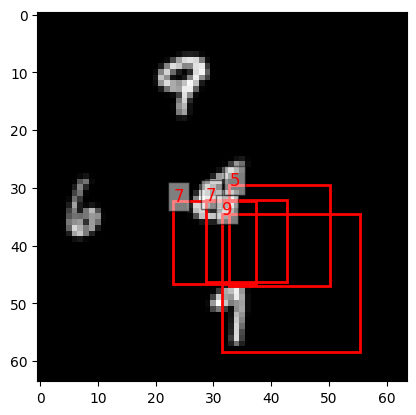

In [40]:

model.eval()
model.cuda()
with torch.no_grad():
    for images, _ in train_loader:
        images = images.to(device)
        outputs = model(images)
        output = _[0].cpu().numpy()  # Take the first image in the batch
        output = outputs[0].cpu().numpy()  # Take the first image in the batch
        # print(_[0])
        # Draw bounding boxes on the image
        image_np = images[0].cpu().squeeze().numpy()
        # draw_bboxes(image_np, output)
        draw_bboxes(image_np, output)
        break

[[ 3.4162002   0.36751717  0.371573    0.21932657  0.21732289]
 [ 3.611568    0.39497152  0.4177311   0.21995865  0.22279875]
 [ 2.8855443   0.21766749  0.1872739   0.06849106  0.06849109]
 [ 0.15671033 -0.4904275  -0.48816112 -0.5397589  -0.5397589 ]]


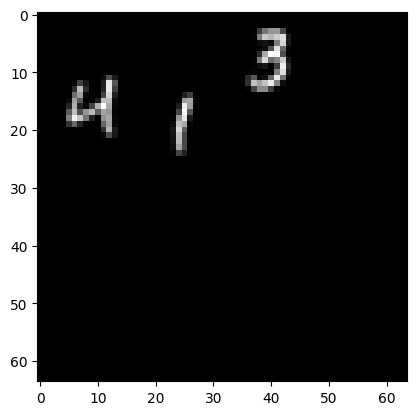

In [41]:
model.eval()
with torch.no_grad():
    for images, _ in train_loader:
        images = images.to(device)
        outputs = model(images)
        print(outputs[0].cpu().numpy())
        image_np = images[0].cpu().squeeze().numpy()  
        plt.imshow(image_np, cmap='gray')
        plt.show()
        break

In [43]:
model = torch.jit.load('model_0605_1745.pt').cuda()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(model)
model.eval()

RecursiveScriptModule(
  original_name=ImprovedCNN
  (conv1): RecursiveScriptModule(original_name=Conv2d)
  (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
  (conv2): RecursiveScriptModule(original_name=Conv2d)
  (bn2): RecursiveScriptModule(original_name=BatchNorm2d)
  (conv3): RecursiveScriptModule(original_name=Conv2d)
  (bn3): RecursiveScriptModule(original_name=BatchNorm2d)
  (conv4): RecursiveScriptModule(original_name=Conv2d)
  (bn4): RecursiveScriptModule(original_name=BatchNorm2d)
  (pool): RecursiveScriptModule(original_name=MaxPool2d)
  (dropout): RecursiveScriptModule(original_name=Dropout)
  (fc1): RecursiveScriptModule(original_name=Linear)
  (fc2): RecursiveScriptModule(original_name=Linear)
)

In [47]:
class TEST_HandwrittenDigitsDataset(Dataset):
    def __init__(self, images_folder, transform=None):
        self.images_folder = images_folder
        self.transform = transform
        self.image_files = [f for f in os.listdir(images_folder) if f.endswith('.png')]
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = cv2.imread(os.path.join(self.images_folder, img_path), cv2.IMREAD_GRAYSCALE)
        if self.transform:
            image = self.transform(image)
        return image, img_path[:-4]
path = "D:\Casper\OTHER\Data\\aML\hw6\HW6_test\\"
test_dataset = TEST_HandwrittenDigitsDataset(path, transform)
print(len(test_dataset))

24000


In [48]:
test_dataset[0]

(tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]),
 '0000003')

In [49]:
def TEST_custom_collate_fn(batch):
    images = []
    for image, img_path in batch:
        images.append(image)
        
    images = torch.stack(images, 0)

    return images, img_path

In [55]:
test_loader = DataLoader(test_dataset, batch_size=1,shuffle=True, collate_fn=TEST_custom_collate_fn)
# display_image_and_tensor(test_dataset, 1)


In [51]:
import csv
with open('model_output.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['IMAGE_index', 'class', 'x', 'y', 'w', 'h'])  # 写入CSV标题行
    
    model.eval()

    with torch.no_grad():
        for images, img_name in test_loader:
            images = images.to(device)
            outputs = model(images)
            # print(outputs[0].cpu().numpy())
            # print(img_name)
            
            # image_np = images[0].cpu().squeeze().numpy()  
            # plt.imshow(image_np, cmap='gray')
            # plt.show()
            output = outputs[0].cpu().numpy()  # Take the first image in the batch
            # print(output)
            # draw_bboxes(image_np, output)
            for item in output:
                # print(item)
                class_id, x_center, y_center, width, height = item
                class_id = int(np.floor(class_id))  # 将类标签取整
                if class_id < 0 or x_center < 0 or y_center < 0 or width < 0 or height < 0:
                    continue  # 跳过包含负值的条目
                writer.writerow([img_name, class_id, x_center, y_center, width, height])
            # break

[[ 1.2475443   0.3419472   0.35080594  0.21918906  0.21748056]
 [ 1.7066779   0.37358767  0.37708813  0.21937525  0.22063571]
 [-1.0218015  -0.81351304 -0.80972016 -0.8117822  -0.81178224]
 [-0.9191141  -0.85289884 -0.86346817 -0.8634635  -0.8634635 ]]


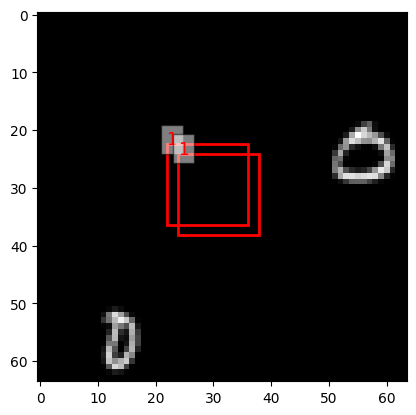

In [88]:
    
model.eval()

with torch.no_grad():
    for images, img_name in test_loader:
        images = images.to(device)
        outputs = model(images)
        # print(outputs[0].cpu().numpy())
        # print(img_name)
        
        image_np = images[0].cpu().squeeze().numpy()  
        # plt.imshow(image_np, cmap='gray')
        # plt.show()
        output = outputs[0].cpu().numpy()  # Take the first image in the batch
        print(output)
        draw_bboxes(image_np, output)
        
        break